# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [131]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import seaborn as sb

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [225]:
class Perceptron:
    def __init__(self, iterations=100):
        self.w = None
        self.iterations = iterations
    
    def fit(self, X, y):
        y_class = y
        y_class[y_class == 0] = -1
        
        self.w = np.random.random_sample(X.shape[1] + 1)
        
        for i in range(self.iterations):
            for j in range(X.shape[0]):
                pred = np.sign(np.sum(self.w[0] + self.w[1:]*X[j]))
                if pred != y_class[j]:
                    self.w[1:] += X[j]*y_class[j]
                    self.w[0] += y_class[j]
            
    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            preds.append(np.sign(np.sum(self.w[0] + self.w[1:]*X[i])))
                
        preds_np = np.array(preds)
        return preds_np

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

[-4.4137991   3.17998477  4.03257765]


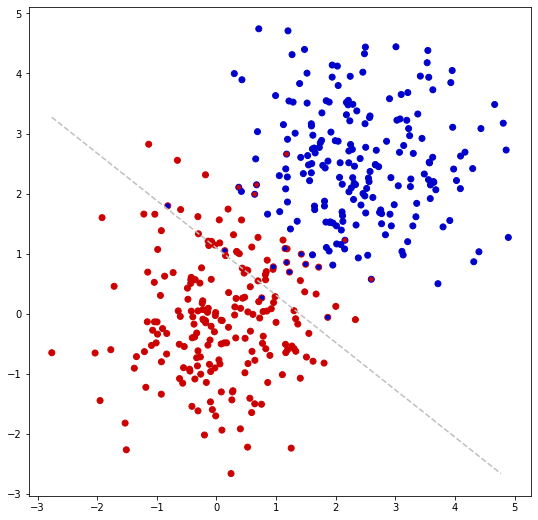

In [41]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
print(c.w)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

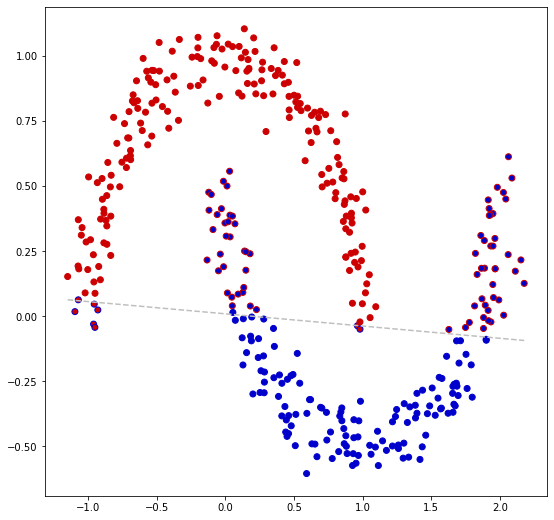

In [42]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [40]:
class PerceptronBest:
    def __init__(self, iterations=100):
        self.w = None
        self.iterations = iterations
    
    def fit(self, X, y):
        y_class = y
        y_class[y_class == 0] = -1
        max_corrected = 0
        max_w = None
        self.w = np.random.random_sample(X.shape[1] + 1)
        
        for i in range(self.iterations):
            corrected = 0
            for j in range(X.shape[0]):
                pred = np.sign(np.sum(self.w[0] + self.w[1:]*X[j]))
                if pred != y_class[j]:
                    self.w[1:] += X[j]*y_class[j]
                    self.w[0] += y_class[j]
                else:
                    corrected += 1
            if max_corrected < corrected:
                max_corrected = corrected
                max_w = self.w
        self.w = max_w
            
    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            preds.append(np.sign(np.sum(self.w[0] + self.w[1:]*X[i])))
                
        preds_np = np.array(preds)
        return preds_np

In [229]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))
    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        #pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        #x, y = list(zip(*pts))
        #plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[int(labels_pred[i])] for i in range(len(labels_pred))]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

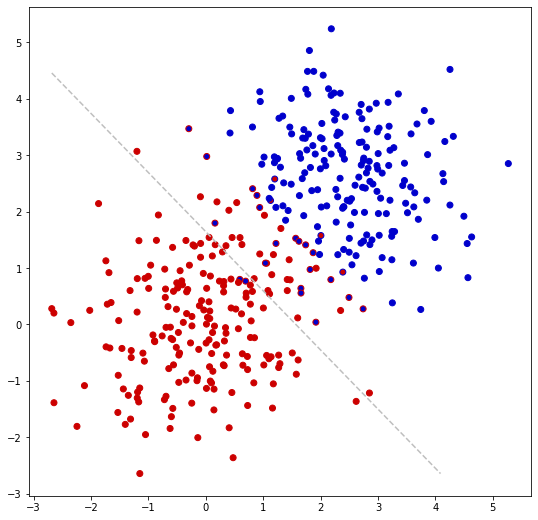

In [45]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

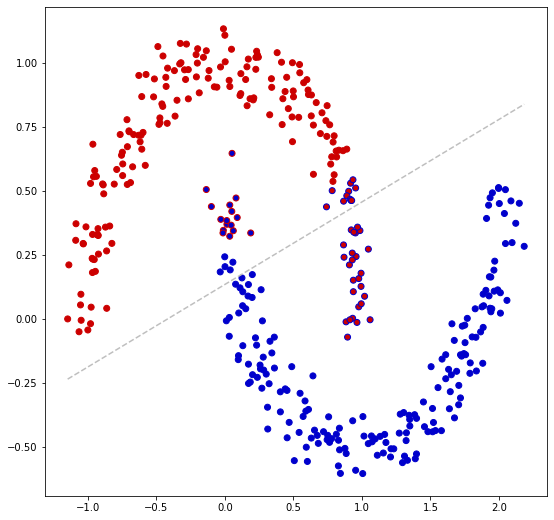

In [46]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [260]:
# Первый параметр - средний индекс самой белой ячейки по строкам
# Второй параметр - средний индекс самой белой ячейки по столбцам
def transform_images(images):
    res = []
    
    for image in images:
        a=0
        b=0
        for i in range(len(image)):
            max_hor = -1
            max_vert = -1
            indv = []
            indh = []
            for j in range(len(image[0])):
                if max_hor < image[i][j]:
                    max_hor = image[i][j]
                    indh.append(j)
                if max_vert < image[j][i]:
                    max_vert = image[j][i]
                    indv.append(j)
        a=np.mean(indh)
        b=np.mean(indv)
        res.append([a, b])
    return np.array(res)

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    labels[labels==y0] = 0
    labels[labels==y1] = 1
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [250]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)


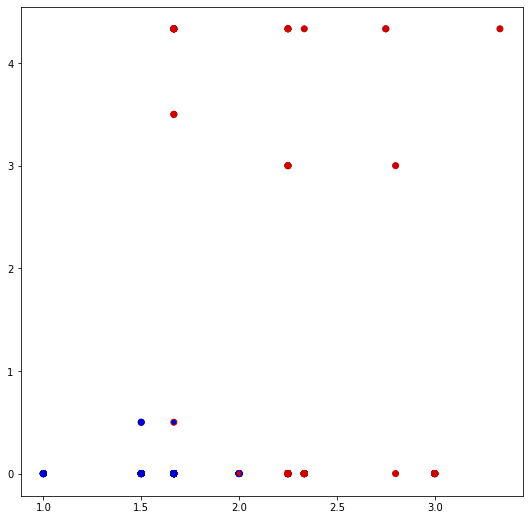

Accuracy: 0.821917808219178


In [254]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
pred = c.predict(X_test)
pred[pred==-1]=0
visualize(X_train, y_train, c.predict(X_train), c.w)
print("Accuracy:", np.mean(pred == y_test))

#### В функции vizualize я закомментировала часть кода, которая рисует линию, так как имеено там почему-то все не работало, хотя судя по рисунку и accuracy все должно быть нормально

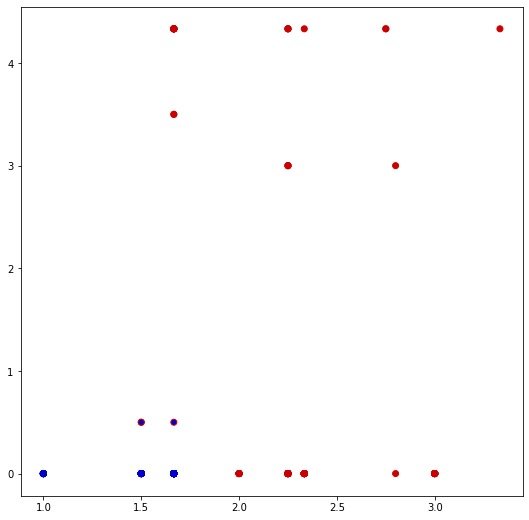

Accuracy: 0.821917808219178


In [256]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
pred = c.predict(X_test)
pred[pred==-1]=0
print("Accuracy:", np.mean(pred == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [265]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.3034703315444842


In [266]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.32141372673722024
